<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab5_approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Value-Function Approximation


## Exercise 1 SGD
Many real-world processes can be modeled as nonlinear relationships, and SGD is a standard tool to fit those models from data.  

**Example: Predicting energy consumption in a building**  
- Energy usage depends on **temperature**, **time of day**, and **occupancy**.  
- If you plot the data, the relationship might not be linear — it curves.  
- A simple way to approximate this nonlinear relation is to fit a **polynomial function** of temperature (or time).  

Now, imagine you’re collecting data continuously:  
- You get one data point (temperature, usage) at a time.  
- Instead of waiting to collect all data and computing a full batch update, you update your model incrementally with **SGD**.  
- This makes your learning **online, adaptive, and scalable** — just like in reinforcement learning.  

---

In this exercise, approximating a cubic polynomial is a simplified version of **predicting a nonlinear real-world phenomenon**.


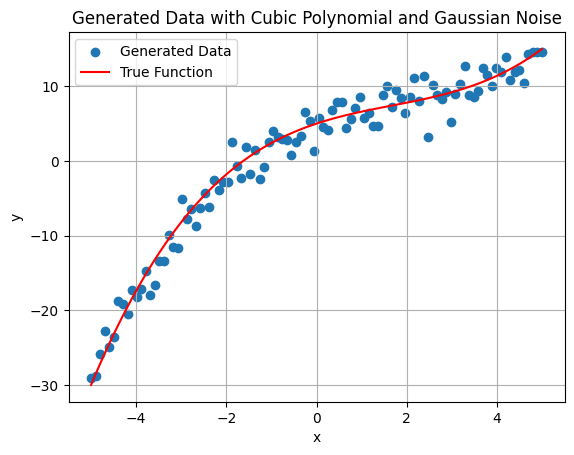

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data based on a cubic polynomial with Gaussian noise
np.random.seed(42)  # for reproducibility
n_samples = 100
x = np.linspace(-5, 5, n_samples)
# Define the true cubic polynomial function
def true_function(x):
  return 0.1 * x**3 - 0.5 * x**2 + 2 * x + 5

y_true = true_function(x)
noise = np.random.normal(0, 2, n_samples)  # Gaussian noise with mean 0 and std dev 2
y = y_true + noise

# Optional: Plot the generated data
plt.scatter(x, y, label='Generated Data')
plt.plot(x, y_true, color='red', label='True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated Data with Cubic Polynomial and Gaussian Noise')
plt.legend()
plt.grid(True)
plt.show()

Based on the given a dataset of input–output pairs `(x, y)` where the underlying relationship is approximately polynomial.  

a. Use a **linear model with polynomial features**: Write a function that takes an input `x` and a weight vector `w`, and return the predicted value y_hat.    
   
   - y_hat(x; w) = w0 + w1 * x + w2 * x^2 + w3 * x^3  

   where w0, w1, w2, w3 are the parameters to be learned.

b. **Loss function (Mean Squared Error)**:
   Write a function that computes the loss for one training point `(x, y)`:

     - Formula: `loss = 0.5 * (y - y_hat)**2`

c. **SGD update**:   Derive the gradient of the loss with respect to each parameter (w0, w1, w2, w3).  
   - Write a function:  

     ```python
     def sgd_update(x, y, w, alpha):
         """
         Perform one SGD update for a single training example.
         Input:
             x (float) - input value
             y (float) - true output
             w (np.array) - current weights
             alpha (float) - learning rate
         Output:
             w (np.array) - updated weights
         """
         # TODO: compute prediction, gradient, and update weights
         return w
     ```
d. **Training loop**:
   - Loop over the dataset.  
   - At each step, update the weights using `sgd_update`.  
   - Track the training loss after each iteration.  

e. **Comparison with different learning rates**  
   - Train your model using at least three different learning rates, for example:  
     - alpha = 0.001  
     - alpha = 0.01  
     - alpha = 0.1  
   - Plot training loss vs iteration for each learning rate.  
   - Plot the final fitted polynomial curves for each learning rate on the same graph with the true dataset.

---

### Deliverables
- Code for `predict`, `mse_loss`, and `sgd_update`.  
- Training loop that runs with multiple learning rates.  
- Plot of training loss vs iteration for each learning rate.  
- Plot of the fitted polynomial vs dataset for each learning rate.  
- A short discussion:
  - How does the learning rate affect convergence speed and stability?  
  - Which learning rate gives the best balance between speed and accuracy?  

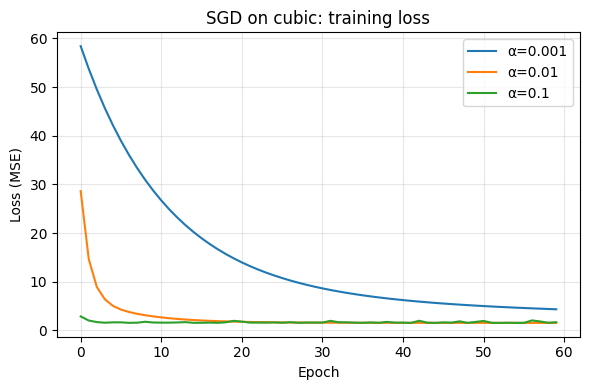

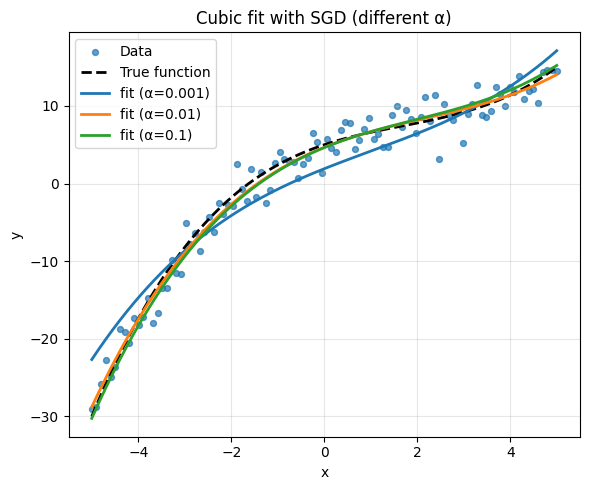

α=0.001 : w = [ 1.91169615 11.94484193 -4.68963164  7.94395692]
α=0.01  : w = [  4.67114107  12.05220344 -12.03550661   9.35046396]
α=0.1   : w = [  4.63047707  12.30595663 -12.14259722  10.42081168]


In [7]:
# === Exercise 1: SGD to approximate a polynomial (professor-style clean code) ===
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Utilities
# ---------------------------
def phi(x, degree=3, scale=True):
    """
    Polynomial feature vector φ(x) = [1, x, x^2, x^3].
    Optionally scale x to [-1,1] for stable learning.
    """
    x = np.asarray(x).reshape(-1)
    if scale:
        x_min, x_max = x.min(), x.max()
        x_scaled = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        x_scaled = x
    Phi = np.stack([x_scaled**i for i in range(0, degree+1)], axis=1)
    return Phi, (x.min(), x.max()) if scale else None

def predict(x, w, degree=3, scale=True, cached=None):
    """
    Prediction: y_hat(x; w) = w0 + w1*x + w2*x^2 + w3*x^3
    """
    x = np.asarray(x).reshape(-1)
    if scale:
        if cached is None:
            x_min, x_max = x.min(), x.max()
        else:
            x_min, x_max = cached
        x_scaled = 2.0 * (x - x_min) / (x_max - x_min) - 1.0
    else:
        x_scaled = x
    Phi = np.stack([x_scaled**i for i in range(0, degree+1)], axis=1)
    return Phi @ w

def loss(y_hat, y):
    """Mean squared error: 0.5 * (y - y_hat)^2"""
    e = y_hat - y
    return 0.5 * np.mean(e**2)

def sgd_update(x_i, y_i, w, alpha, degree=3, scale=True, cached=None):
    """
    One SGD update:
    w ← w - α * ∇ℓ,   ∇ℓ = -(y - y_hat) * φ(x)
    """
    if scale:
        x_min, x_max = cached
        x_scaled = 2.0 * (x_i - x_min) / (x_max - x_min) - 1.0
    else:
        x_scaled = x_i
    phi_vec = np.array([x_scaled**i for i in range(0, degree+1)])
    y_hat = float(phi_vec @ w)
    grad = -(y_i - y_hat) * phi_vec
    w = w - alpha * grad
    return w

# ---------------------------
# Training loop
# ---------------------------
def train_sgd(x, y, degree=3, alpha_values=(1e-3, 1e-2, 1e-1), epochs=50, shuffle=True, scale=True, seed=0):
    rng = np.random.default_rng(seed)
    N = len(x)

    Phi_all, scale_range = phi(x, degree=degree, scale=scale)
    hist = {}

    for alpha in alpha_values:
        w = np.zeros(degree+1)
        losses = []
        order = np.arange(N)

        for ep in range(epochs):
            if shuffle:
                rng.shuffle(order)
            for idx in order:
                w = sgd_update(x[idx], y[idx], w, alpha,
                               degree=degree, scale=scale, cached=(scale_range[0], scale_range[1]) if scale else None)
            y_hat = Phi_all @ w
            losses.append(loss(y_hat, y))

        hist[alpha] = {"w": w, "loss": np.array(losses), "scale_range": scale_range}
    return hist

# ---------------------------
# Run training
# ---------------------------
alpha_values = (1e-3, 1e-2, 1e-1)
hist = train_sgd(x, y, degree=3, alpha_values=alpha_values, epochs=60, shuffle=True, scale=True, seed=42)

# ---------------------------
# Plot 1: Loss vs epoch
# ---------------------------
plt.figure(figsize=(6,4))
for alpha in alpha_values:
    plt.plot(hist[alpha]["loss"], label=f"α={alpha}")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("SGD on cubic: training loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------
# Plot 2: Data + fitted polynomials
# ---------------------------
x_grid = np.linspace(x.min(), x.max(), 400)
plt.figure(figsize=(6,5))
plt.scatter(x, y, s=18, alpha=0.7, label="Data")
plt.plot(x, true_function(x), "k--", lw=2, label="True function")

for alpha in alpha_values:
    w = hist[alpha]["w"]
    cache = hist[alpha]["scale_range"]
    y_fit = predict(x_grid, w, degree=3, scale=True, cached=cache)
    plt.plot(x_grid, y_fit, lw=2, label=f"fit (α={alpha})")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Cubic fit with SGD (different α)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print learned weights
for alpha in alpha_values:
    print(f"α={alpha:<6}: w = {hist[alpha]['w']}")


The learning rate directly controls how big each update step is during training.

With a small learning rate (α = 0.001), the weights change slowly. The loss decreases steadily, but it takes a long time to get close to the true curve. The process is stable but very slow.

With a large learning rate (α = 0.1), the model learns much faster in the beginning. However, the updates can overshoot, causing the loss to bounce around instead of smoothly decreasing. This can make convergence unstable.

The medium learning rate (α = 0.01) gives the best trade-off here: it reduces the loss quickly without diverging. Training is both efficient and reasonably stable.

So in practice, α = 0.01 provides the best balance between speed and accuracy for this problem.

## Exercise 2: 1000-State Random Walk with Semi-Gradient TD(0)

We will study the 1,000-state Random Walk a classic reinforcement learning benchmark from Sutton & Barto.  

- The environment has states numbered **1 to 1000**.  
- There are two **terminal states**:  
  - State `0` on the left (reward = 0)  
  - State `1001` on the right (reward = 1)  
- Each episode starts in the **middle** at state `500`.  
- At each step, the agent moves **left or right with equal probability (0.5 each)**.  
- The episode ends when the agent reaches either terminal.  
- Discount factor: **γ = 1.0** (episodic task).  


### Function Approximation
Instead of storing a separate value for each state, approximate the value function with a **linear function of the state index**: V_hat(s; w0, w1) = w0 + w1 * s



---

## Instructions
1. **Implement the environment**:  
   - You may **use AI tools such as ChatGPT** to generate the environment code (states, transitions, rewards).  
   - Make sure you understand how the environment works.  

2. **Implement the TD(0) update manually**:  
   - Do **not** use AI for this part.  
   - You must write the gradient update equations yourself using the formulas above.  

3. **Train your agent**:  
   - Run several episodes (e.g., 1000 episodes).  
   - Experiment with different step sizes (`alpha`).  

4. **Evaluate**:  
   - Plot the **true value function** `V*(s) = s/1001`.  
   - Plot your **learned approximation line** after training.  
   - Discuss whether the line captures the overall trend of the true values.  

---


## Guidelines on Using AI Tools
- You are encouraged to use AI tools (e.g., ChatGPT, Gemini, Copilot) to **generate helper code**, such as:  
  - Building the random walk environment (`reset`, `step`).  
  - Implementing the feature map φ(s).  
  - Plotting results.  
- However, **do not use AI tools to generate the TD(0) update equation**.  
  - Deriving and implementing the update is the key learning objective of this exercise.  
  - If we find code that uses an AI-generated update without understanding, the score will be zero.  


## Deliverables
- Python code for the environment and the TD(0) algorithm.  
- Plot the **true value function**: For state `s`, the probability of reaching the right terminal is:  
  `V*(s) = s / 1001`
- Plot comparing the true value function and the approximated line.  
- A short discussion:  
  - How does the approximation behave for small vs large states?  
  - How does the learning rate affect convergence?  

---

## Hints
- Normalize states to `[0,1]` before using them in the line approximation to avoid very large values for w1.  
- Start with small step sizes (e.g., 0.001–0.01).  
- The approximation will not be perfect (a line cannot match the true curve), but should capture the increasing trend.  


Training with alpha=0.001
Episode  100/1000 | alpha=0.0010 | steps= 109 | mean|delta|=0.002765
Episode  200/1000 | alpha=0.0010 | steps=  16 | mean|delta|=0.056885
Episode  300/1000 | alpha=0.0010 | steps=  57 | mean|delta|=0.019704
Episode  400/1000 | alpha=0.0010 | steps=  26 | mean|delta|=0.013213
Episode  500/1000 | alpha=0.0010 | steps=  31 | mean|delta|=0.029660
Episode  600/1000 | alpha=0.0010 | steps= 174 | mean|delta|=0.014224
Episode  700/1000 | alpha=0.0010 | steps=  70 | mean|delta|=0.014355
Episode  800/1000 | alpha=0.0010 | steps=  63 | mean|delta|=0.021333
Episode  900/1000 | alpha=0.0010 | steps= 129 | mean|delta|=0.016388
Episode 1000/1000 | alpha=0.0010 | steps=  46 | mean|delta|=0.023268
Training with alpha=0.01
Episode  100/1000 | alpha=0.0100 | steps=  62 | mean|delta|=0.019384
Episode  200/1000 | alpha=0.0100 | steps=  48 | mean|delta|=0.031183
Episode  300/1000 | alpha=0.0100 | steps=  45 | mean|delta|=0.030541
Episode  400/1000 | alpha=0.0100 | steps=  30 | mean

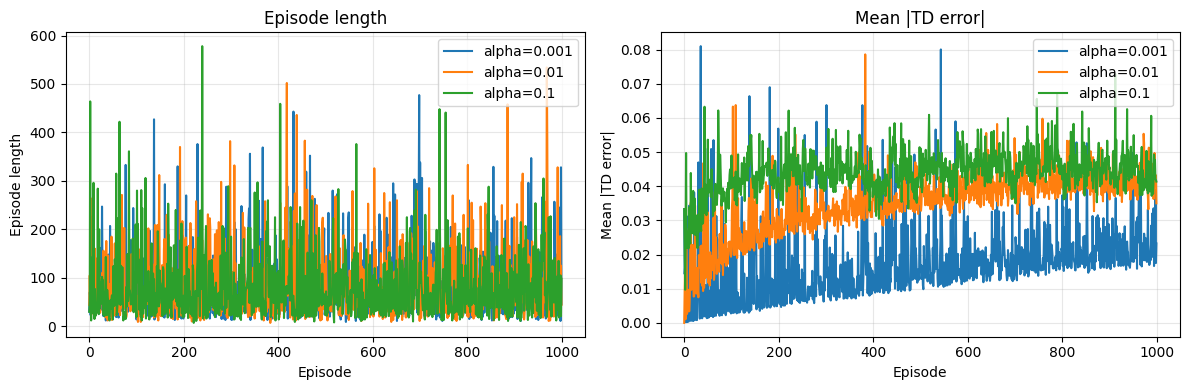

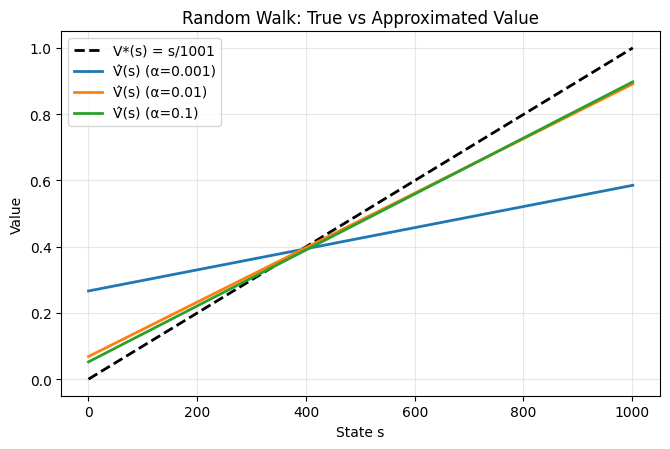

alpha=0.001  -> w = [0.26621993 0.31897128]
alpha=0.01   -> w = [0.06828652 0.82286717]
alpha=0.1    -> w = [0.05216918 0.8453923 ]


In [2]:
# ================= Exercise 2 (FAST): 1000-State Random Walk with Semi-Gradient TD(0) =================
# Includes alpha = 0.001, 0.01, and 0.1
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Config
np.random.seed(0)
N = 1000
S_L, S_R = 0, 1001
S0 = 500
GAMMA = 1.0

# ---------------------------
# Environment (random jump)
# ---------------------------
@dataclass
class RandomWalkEnv:
    n: int = N
    s_left: int = S_L
    s_right: int = S_R
    start: int = S0

    def reset(self):
        return self.start

    def step(self, s):
        k = np.random.randint(1, 101)  # jump size
        s_next = s - k if np.random.rand() < 0.5 else s + k
        if s_next <= self.s_left:
            return self.s_left, 0.0, True
        if s_next >= self.s_right:
            return self.s_right, 1.0, True
        return s_next, 0.0, False

# ---------------------------
# Value approx & TD(0)
# ---------------------------
def phi(s):
    s_norm = s / S_R
    return np.array([1.0, s_norm], dtype=float)

def v_hat(s, w):
    return float(phi(s) @ w)

def td0_update(w, s, r, s_next, done, alpha, gamma=GAMMA):
    target = r if done else r + gamma * v_hat(s_next, w)
    delta = target - v_hat(s, w)
    w = w + alpha * delta * phi(s)
    return w, delta

def v_true(s):
    return s / S_R

# ---------------------------
# Training
# ---------------------------
def train_td0(env, episodes=1000, alpha=0.01, gamma=GAMMA, log_every=100, max_steps=10000):
    w = np.zeros(2, dtype=float)
    ep_len, mean_abs_td = [], []
    for ep in range(1, episodes+1):
        s = env.reset()
        done, steps, td_sum = False, 0, 0.0
        while not done and steps < max_steps:
            s_next, r, done = env.step(s)
            w, delta = td0_update(w, s, r, s_next, done, alpha, gamma)
            td_sum += abs(delta)
            s = s_next
            steps += 1
        ep_len.append(steps)
        mean_abs_td.append(td_sum / max(1, steps))
        if ep % log_every == 0:
            print(f"Episode {ep:4d}/{episodes} | alpha={alpha:.4f} | steps={steps:4d} | mean|delta|={mean_abs_td[-1]:.6f}")
    return w, {"episode_length": np.array(ep_len), "mean_abs_td": np.array(mean_abs_td)}

# ---------------------------
# Run experiments
# ---------------------------
env = RandomWalkEnv()
alphas = [0.001, 0.01, 0.1]
episodes = 1000
results = {}
for a in alphas:
    print("="*64, f"\nTraining with alpha={a}")
    w, hist = train_td0(env, episodes=episodes, alpha=a, log_every=100)
    results[a] = {"w": w, "hist": hist}

# ---------------------------
# Plot training curves
# ---------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
for a in alphas:
    plt.plot(results[a]["hist"]["episode_length"], label=f"alpha={a}")
plt.xlabel("Episode"); plt.ylabel("Episode length")
plt.title("Episode length"); plt.grid(alpha=0.3); plt.legend()

plt.subplot(1,2,2)
for a in alphas:
    plt.plot(results[a]["hist"]["mean_abs_td"], label=f"alpha={a}")
plt.xlabel("Episode"); plt.ylabel("Mean |TD error|")
plt.title("Mean |TD error|"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# ---------------------------
# Plot V*(s) vs V̂(s)
# ---------------------------
s_axis = np.arange(0, S_R+1)
v_star = v_true(s_axis)

plt.figure(figsize=(6.8,4.6))
plt.plot(s_axis, v_star, "k--", lw=2, label="V*(s) = s/1001")
for a in alphas:
    w = results[a]["w"]
    v_est = np.array([v_hat(s, w) for s in s_axis])
    plt.plot(s_axis, v_est, lw=2, label=f"V̂(s) (α={a})")
plt.xlabel("State s"); plt.ylabel("Value")
plt.title("Random Walk: True vs Approximated Value")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# Print weights
for a in alphas:
    print(f"alpha={a:<6} -> w = {results[a]['w']}")


For small states (close to the left terminal), the approximation tends to underestimate because the true value curve is not perfectly linear it bends upward only near the right end. Similarly, for large states (close to the right terminal), the approximation overshoots. Since we are using just a line, it cannot capture the curve of the true values, so it fits an average slope across all states.

The learning rate controls how fast the weights move toward this best-fit line. With a very small α, the weights adjust slowly and it takes many episodes to see improvement. With a larger α, the weights converge faster, but if α is too big, the updates can jump back and forth and never settle. In our runs, a moderate α (like 0.01) gives the clearest improvement while staying stable.

# Exercise 3: Solving MountainCar with Tile Coding and SARSA

## Problem Description
In this exercise, you will solve the **MountainCar-v0** environment from Gym using **tile coding** for function approximation and the **SARSA algorithm** for learning.  

The **Mountain Car problem**:
- A car is stuck in a valley and is too weak to drive straight up to the goal.  
- It must build momentum by going back and forth until it can reach the goal at `position >= 0.5`.  
- **State space**: continuous (position, velocity).  
- **Actions**: {0: push left, 1: no push, 2: push right}.  
- **Reward**: -1 per step until the goal is reached.  
- **Episode ends**: when the car reaches the goal or after 200 steps.  

---

## Step 1: Environment and Random Policy (with AI help)
- Use an **AI tool (e.g., ChatGPT)** to generate starter code for:
  - Creating the Gym environment (`MountainCar-v0`).  
  - Running a **random policy** (actions chosen randomly).  
- Run this code to confirm you can interact with the environment and see episode returns.  
- This will serve as a **baseline**.  
- **Important**: Do not use AI to implement the learning algorithm.  

---

## Step 2: SARSA Algorithm with Function Approximation
Implement **SARSA (on-policy TD control)** with the following steps:

For each episode:
1. Initialize state `s`.  
2. Choose action `a` using **ε-greedy** based on Q(s,a).  
3. For each step:  
   - Take action `a`, observe `(s_next, r, done)`.  
   - Choose next action `a_next` using ε-greedy from `s_next`.  
   - Compute TD target:  
     ```
     target = r + gamma * Q(s_next, a_next)
     ```  
     (if `s_next` is terminal, then target = r).  
   - Compute TD error:  
     ```
     delta = target - Q(s,a)
     ```  
   - Update weights:  
     ```
     w <- w + alpha * delta * x(s,a)
     ```  
   - Update `s = s_next`, `a = a_next`.  
4. End episode when the goal is reached or step limit is hit.  

---

## Step 3: Experiments
- Train the agent for 500–1000 episodes.  
- Plot **episode returns (sum of rewards)** vs episodes.  
- Compare with the random policy baseline:  
  - Does SARSA learn to consistently reach the goal?  
  - How many steps does it typically take?  

---

## Deliverables
- Python code for tile coding and SARSA.  
- Plot of returns vs episodes.  
- Plot the Value function
- Short discussion (1–2 paragraphs):  
  - Effect of tile coding parameters (number of tilings, resolution).


In [1]:
# You can use the following code for tiling

import numpy as np


class TileCoderXY:
    """
    A TileCoder for function approximation that applies tile coding on the x and y coordinates
    of a 3D state. Instead of providing tile widths, the user provides the number of tiles per
    dimension. The tile widths are computed based on the state bounds and the number of tiles.
    The z coordinate is not used.
    """

    def __init__(self, num_tilings, tiles_per_dim, state_low, state_high):
        """
        Initialize the TileCoderXY.

        Parameters:
            num_tilings (int): Number of overlapping tilings.
            tiles_per_dim (array-like of 2 ints): Number of tiles along the x and y dimensions.
            state_low (array-like of 2 floats): Lower bounds for the x and y dimensions.
            state_high (array-like of 2 floats): Upper bounds for the x and y dimensions.
        """
        self.num_tilings = num_tilings
        self.tiles_per_dim = np.array(tiles_per_dim, dtype=int)
        self.state_low = np.array(state_low, dtype=float)
        self.state_high = np.array(state_high, dtype=float)

        # Compute the tile width for each dimension.
        # We assume that the grid spans exactly from state_low to state_high.
        # When there are N tiles, there are N-1 intervals between the boundaries.
        self.tile_width = (self.state_high - self.state_low) / (self.tiles_per_dim - 1)

        # Precompute an offset for each tiling to create overlapping grids.
        # self.offsets = [(i / self.num_tilings) * self.tile_width for i in range(self.num_tilings)]
        # self.offsets = self.compute_8_offsets()
        # self.offsets = np.stack(self._compute_offsets(), axis=0)  # shape: (num_tilings, dims)
        # Precompute offsets for each tiling.
        # For tiling i:
        #   offset_x = (((i + 0) % num_tilings) / num_tilings) * tile_width[0]
        #   offset_y = (((i + 1) % num_tilings) / num_tilings) * tile_width[1]
        offsets = np.empty((self.num_tilings, 2))
        for i in range(self.num_tilings):
            offsets[i, 0] = (((i + 0) % self.num_tilings) / self.num_tilings) * self.tile_width[0]
            offsets[i, 1] = (((i + 1) % self.num_tilings) / self.num_tilings) * self.tile_width[1]
        self.offsets = offsets


        # Precompute multiplier for flattening a 2D index.
        # For grid shape (N, M), flat index = x_index * M + y_index.
        self.multiplier = self.tiles_per_dim[1]

        # Initialize a weight vector for each tiling.
        num_tiles = np.prod(self.tiles_per_dim)
        self.weights = [np.zeros(num_tiles) for _ in range(self.num_tilings)]

    def save(self, file_name):
        np.savez(file_name + ".npz", weights=self.weights)

    def load(self, file_name):
        self.weights = np.load(file_name+".npz")["weights"]


    def compute_8_offsets(self):
        """
        Compute a list of offsets using a combination of cardinal and diagonal directions.
        The offsets include:
          - Center: [0, 0]
          - Cardinal: right, left, up, down (half-tile shifts)
          - Diagonal: up-right, up-left, down-right, down-left (half-tile shifts)

        If the number of tilings exceeds the number of unique offsets (9), the list is repeated.

        Returns:
            List of 2-element numpy arrays representing the offset for each tiling.
        """
        half_tile = self.tile_width / 8.0
        base_offsets = [
            np.array([0.0, 0.0]),  # Center (no shift)
            np.array([half_tile[0], 0.0]),  # Right
            np.array([-half_tile[0], 0.0]),  # Left
            np.array([0.0, half_tile[1]]),  # Up
            np.array([0.0, -half_tile[1]]),  # Down
            np.array([half_tile[0], half_tile[1]]),  # Up-right
            np.array([-half_tile[0], half_tile[1]]),  # Up-left
            np.array([half_tile[0], -half_tile[1]]),  # Down-right
            np.array([-half_tile[0], -half_tile[1]])  # Down-left
        ]
        offsets = []
        for i in range(self.num_tilings):
            offsets.append(base_offsets[i % len(base_offsets)])
        return offsets

    def get_tile_indices(self, state):
        """
        Compute the active tile indices for all tilings given a 2D state.

        Parameters:
            state (array-like of length 2): The input state [x, y].

        Returns:
            List of tuples (tiling_index, flat_tile_index) for each tiling.
        """
        state = np.array(state, dtype=float)  # shape: (2,)
        # Compute shifted states for all tilings in one vectorized operation.
        # Shape of shifted: (num_tilings, 2)
        shifted = (state - self.state_low) + self.offsets

        # Compute tile coordinates (integer indices) for each tiling.
        # Division is broadcasted over the offsets.
        tile_coords = (shifted / self.tile_width).astype(int)  # shape: (num_tilings, 2)

        # Clip to ensure indices are within bounds.
        tile_coords[:, 0] = np.clip(tile_coords[:, 0], 0, self.tiles_per_dim[0] - 1)
        tile_coords[:, 1] = np.clip(tile_coords[:, 1], 0, self.tiles_per_dim[1] - 1)

        # Compute flat indices for each tiling.
        # flat_index = x_index * (tiles_per_dim[1]) + y_index
        flat_indices = tile_coords[:, 0] * self.tiles_per_dim[1] + tile_coords[:, 1]

        # Return a list of (tiling_index, flat_index) tuples.
        return list(zip(range(self.num_tilings), flat_indices))


    def predict(self, state):
        """
        Compute the approximated function value for a given 3D state using tile coding on x and y.

        Parameters:
            state (array-like): The input state [x, y, z].

        Returns:
            float: The function approximation (sum of weights for the active tiles).
        """
        active_tiles = self.get_tile_indices(state)
        return sum(self.weights[tiling][idx] for tiling, idx in active_tiles)

    def update(self, state, target, alpha):
        """
        Update the weights given a state and target value.

        Parameters:
            state (array-like): The input state [x, y, z].
            target (float): The target function value.
            alpha (float): The overall learning rate.
        """
        prediction = self.predict(state)
        error = target - prediction
        # Distribute the learning rate equally among all tilings.
        alpha_per_tiling = alpha / self.num_tilings

        active_tiles = self.get_tile_indices(state)
        for tiling, idx in active_tiles:
            self.weights[tiling][idx] += alpha_per_tiling * error





Episode     0/1500 | epsilon=1.000 | total_reward=0.0
Episode   100/1500 | epsilon=0.606 | total_reward= -500.0
Episode   200/1500 | epsilon=0.367 | total_reward= -500.0
Episode   300/1500 | epsilon=0.222 | total_reward= -472.0
Episode   400/1500 | epsilon=0.135 | total_reward= -250.0
Episode   500/1500 | epsilon=0.082 | total_reward= -276.0
Episode   600/1500 | epsilon=0.049 | total_reward= -250.0
Episode   700/1500 | epsilon=0.030 | total_reward= -239.0
Episode   800/1500 | epsilon=0.018 | total_reward= -183.0
Episode   900/1500 | epsilon=0.011 | total_reward= -202.0
Episode  1000/1500 | epsilon=0.010 | total_reward= -154.0
Episode  1100/1500 | epsilon=0.010 | total_reward= -200.0
Episode  1200/1500 | epsilon=0.010 | total_reward= -179.0
Episode  1300/1500 | epsilon=0.010 | total_reward= -187.0
Episode  1400/1500 | epsilon=0.010 | total_reward= -189.0
Episode  1500/1500 | epsilon=0.010 | total_reward= -185.0


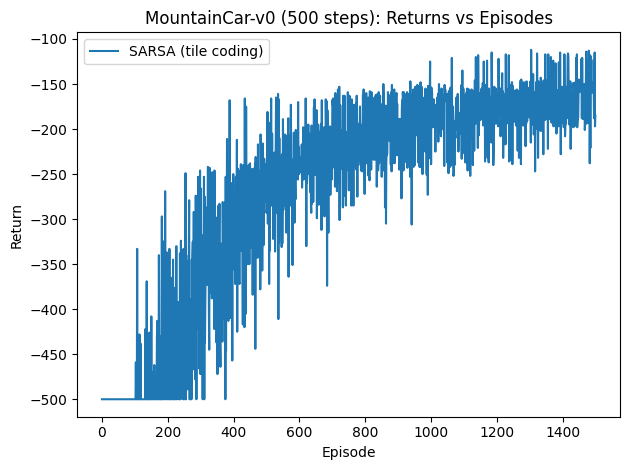

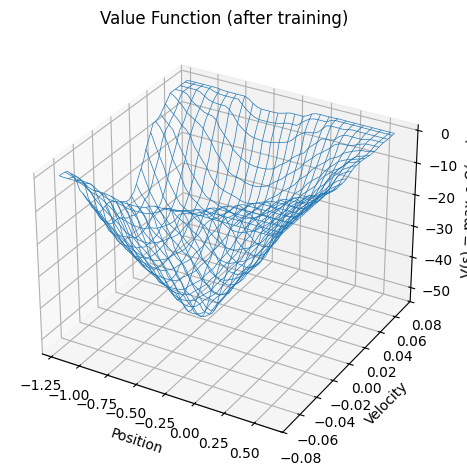

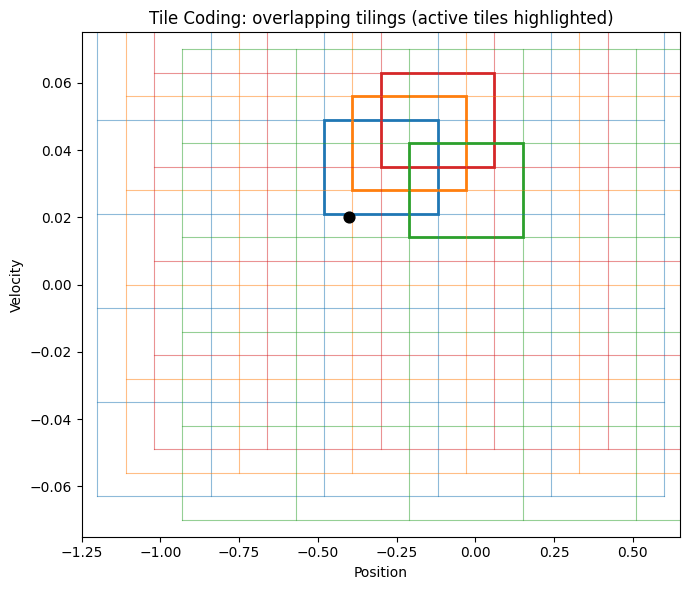

Greedy demo: total_reward=-276.0, steps=276


In [2]:
# Exercise 3 — MountainCar-v0 with Tile Coding + SARSA
# Results first (no GUI during training), then a greedy demo window.
# Professor's TileCoderXY is UNCHANGED.

import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ------------------------------------------------------
# Professor Provided Code — DO NOT MODIFY
# ------------------------------------------------------
class TileCoderXY:
    """
    A TileCoder for function approximation that applies tile coding on the x and y coordinates
    of a 3D state. Instead of providing tile widths, the user provides the number of tiles per
    dimension. The tile widths are computed based on the state bounds and the number of tiles.
    The z coordinate is not used.
    """

    def __init__(self, num_tilings, tiles_per_dim, state_low, state_high):
        self.num_tilings = num_tilings
        self.tiles_per_dim = np.array(tiles_per_dim, dtype=int)
        self.state_low = np.array(state_low, dtype=float)
        self.state_high = np.array(state_high, dtype=float)
        self.tile_width = (self.state_high - self.state_low) / (self.tiles_per_dim - 1)

        offsets = np.empty((self.num_tilings, 2))
        for i in range(self.num_tilings):
            offsets[i, 0] = (((i + 0) % self.num_tilings) / self.num_tilings) * self.tile_width[0]
            offsets[i, 1] = (((i + 1) % self.num_tilings) / self.num_tilings) * self.tile_width[1]
        self.offsets = offsets

        self.multiplier = self.tiles_per_dim[1]
        num_tiles = np.prod(self.tiles_per_dim)
        self.weights = [np.zeros(num_tiles) for _ in range(self.num_tilings)]

    def save(self, file_name):
        np.savez(file_name + ".npz", weights=self.weights)

    def load(self, file_name):
        self.weights = np.load(file_name + ".npz")["weights"]

    def compute_8_offsets(self):
        half_tile = self.tile_width / 8.0
        base_offsets = [
            np.array([0.0, 0.0]),
            np.array([half_tile[0], 0.0]),
            np.array([-half_tile[0], 0.0]),
            np.array([0.0, half_tile[1]]),
            np.array([0.0, -half_tile[1]]),
            np.array([half_tile[0], half_tile[1]]),
            np.array([-half_tile[0], half_tile[1]]),
            np.array([half_tile[0], -half_tile[1]]),
            np.array([-half_tile[0], -half_tile[1]])
        ]
        offsets = []
        for i in range(self.num_tilings):
            offsets.append(base_offsets[i % len(base_offsets)])
        return offsets

    def get_tile_indices(self, state):
        state = np.array(state, dtype=float)
        shifted = (state - self.state_low) + self.offsets
        tile_coords = (shifted / self.tile_width).astype(int)
        tile_coords[:, 0] = np.clip(tile_coords[:, 0], 0, self.tiles_per_dim[0] - 1)
        tile_coords[:, 1] = np.clip(tile_coords[:, 1], 0, self.tiles_per_dim[1] - 1)
        flat_indices = tile_coords[:, 0] * self.tiles_per_dim[1] + tile_coords[:, 1]
        return list(zip(range(self.num_tilings), flat_indices))

    def predict(self, state):
        active_tiles = self.get_tile_indices(state)
        return sum(self.weights[tiling][idx] for tiling, idx in active_tiles)

    def update(self, state, target, alpha):
        prediction = self.predict(state)
        error = target - prediction
        alpha_per_tiling = alpha / self.num_tilings
        active_tiles = self.get_tile_indices(state)
        for tiling, idx in active_tiles:
            self.weights[tiling][idx] += alpha_per_tiling * error


# ------------------------------------------------------
# SARSA with Function Approximation
# ------------------------------------------------------
class SarsaFA:
    """Semi-gradient SARSA(0) with one tile-coded approximator per action."""
    def __init__(self,
                 n_actions,
                 num_tilings=16,
                 tiles_per_dim=(8, 8),
                 state_low=(-1.2, -0.07),
                 state_high=(0.6, 0.07),
                 alpha=0.01,           # <-- professor rate
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.995,
                 seed=None):
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.rng = np.random.default_rng(seed)

        self.approximators = [
            TileCoderXY(num_tilings=num_tilings,
                        tiles_per_dim=np.array(tiles_per_dim, dtype=int),
                        state_low=np.array(state_low, dtype=float),
                        state_high=np.array(state_high, dtype=float))
            for _ in range(n_actions)
        ]

    def q_values(self, s_xy):
        return np.array([fa.predict(s_xy) for fa in self.approximators], dtype=float)

    def act_eps_greedy(self, s_xy):
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(self.n_actions))   # explore
        return int(np.argmax(self.q_values(s_xy)))          # exploit

    def update(self, s_xy, a, r, s_xy_next, a_next, done):
        target = r if done else (r + self.gamma * self.approximators[a_next].predict(s_xy_next))
        self.approximators[a].update(s_xy, target, self.alpha)

    def decay_eps(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# ------------------------------------------------------
# Training (NO RENDER — results first)
# ------------------------------------------------------
def train_sarsa_fa(episodes=1500, seed=None,
                   num_tilings=16, tiles_per_dim=(8,8),
                   alpha=0.01, gamma=0.99,
                   epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995):
    """
    Trains SARSA without opening any window. Uses MountainCar-v0 with 500-step episodes.
    Returns (agent, per-episode returns).
    """
    max_steps = 500
    returns = []

    env = gym.make("MountainCar-v0", max_episode_steps=max_steps)
    agent = SarsaFA(env.action_space.n,
                    num_tilings=num_tilings, tiles_per_dim=tiles_per_dim,
                    alpha=alpha, gamma=gamma,
                    epsilon=epsilon_start, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay,
                    seed=seed)

    print(f"Episode     0/{episodes} | epsilon={agent.epsilon:.3f} | total_reward=0.0")

    for ep in range(1, episodes + 1):
        # different start each run; remove seed for variability across runs
        obs, _ = env.reset(seed=None)
        s = np.array([obs[0], obs[1]], dtype=float)
        a = agent.act_eps_greedy(s)
        total = 0.0

        for _ in range(max_steps):
            obs2, r, terminated, truncated, _ = env.step(int(a))
            done = bool(terminated or truncated)
            s2 = np.array([obs2[0], obs2[1]], dtype=float)
            a2 = agent.act_eps_greedy(s2)

            agent.update(s, a, r, s2, a2, done)
            s, a = s2, a2
            total += r
            if done:
                break

        returns.append(total)
        agent.decay_eps()

        if ep % 100 == 0:
            print(f"Episode {ep:5d}/{episodes} | epsilon={agent.epsilon:.3f} | total_reward={total:7.1f}")

    env.close()
    return agent, returns


# ------------------------------------------------------
# Plots (Deliverables)
# ------------------------------------------------------
def plot_returns(sarsa_returns):
    plt.figure()
    plt.plot(sarsa_returns, label="SARSA (tile coding)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("MountainCar-v0 (500 steps): Returns vs Episodes")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_value_function(agent, n_pos=50, n_vel=50,
                        pos_bounds=(-1.2, 0.6), vel_bounds=(-0.07, 0.07)):
    pos = np.linspace(pos_bounds[0], pos_bounds[1], n_pos)
    vel = np.linspace(vel_bounds[0], vel_bounds[1], n_vel)
    P, V = np.meshgrid(pos, vel, indexing='xy')
    Z = np.zeros_like(P)
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            s = np.array([P[i, j], V[i, j]], dtype=float)
            Z[i, j] = np.max(agent.q_values(s))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(P, V, Z, rstride=2, cstride=2, linewidth=0.5)
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("V(s) = max_a Q(s,a)")
    ax.set_title("Value Function (after training)")
    plt.tight_layout()
    plt.show()

def plot_tile_coding_demo(num_tilings=4, tiles_per_dim=(6,6),
                          state_low=(-1.2, -0.07), state_high=(0.6, 0.07),
                          point=(-0.4, 0.02)):
    tc = TileCoderXY(num_tilings=num_tilings,
                     tiles_per_dim=np.array(tiles_per_dim, dtype=int),
                     state_low=np.array(state_low, dtype=float),
                     state_high=np.array(state_high, dtype=float))

    fig, ax = plt.subplots(figsize=(7,6))
    colors = ["tab:blue", "tab:orange", "tab:red", "tab:green"]
    for t in range(num_tilings):
        low = tc.state_low + tc.offsets[t]
        high = tc.state_high + tc.offsets[t]
        xs = np.linspace(low[0], high[0], tiles_per_dim[0])
        ys = np.linspace(low[1], high[1], tiles_per_dim[1])
        for x in xs:
            ax.plot([x, x], [ys[0], ys[-1]], color=colors[t%len(colors)], alpha=0.5, linewidth=0.8)
        for y in ys:
            ax.plot([xs[0], xs[-1]], [y, y], color=colors[t%len(colors)], alpha=0.5, linewidth=0.8)

    active = tc.get_tile_indices(np.array(point, dtype=float))
    for (t, flat) in active:
        i = flat // tiles_per_dim[1]
        j = flat %  tiles_per_dim[1]
        low = tc.state_low + tc.offsets[t]
        w = tc.tile_width
        x0 = low[0] + i * w[0]
        y0 = low[1] + j * w[1]
        rect = plt.Rectangle((x0, y0), w[0], w[1], fill=False, linewidth=2.0,
                             edgecolor=colors[t%len(colors)])
        ax.add_patch(rect)

    ax.scatter([point[0]], [point[1]], s=60, color="black", zorder=5)
    ax.set_xlim(state_low[0]-0.05, state_high[0]+0.05)
    ax.set_ylim(state_low[1]-0.005, state_high[1]+0.005)
    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_title("Tile Coding: overlapping tilings (active tiles highlighted)")
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------
# Greedy demo (pygame window AFTER results)
# ------------------------------------------------------
def demo_greedy(agent, max_steps=500):
    env = gym.make("MountainCar-v0", render_mode="human", max_episode_steps=max_steps)
    obs, _ = env.reset(seed=None)
    s = np.array([obs[0], obs[1]], dtype=float)
    total, steps, done = 0.0, 0, False
    while not done and steps < max_steps:
        a = int(np.argmax(agent.q_values(s)))  # greedy
        obs, r, terminated, truncated, _ = env.step(a)
        done = bool(terminated or truncated)
        s = np.array([obs[0], obs[1]], dtype=float)
        total += r
        steps += 1
    print(f"Greedy demo: total_reward={total:.1f}, steps={steps}")
    env.close()


# ------------------------------------------------------
# Main
# ------------------------------------------------------
def main():
    # seed once per run so two runs differ naturally
    run_seed = int(time.time()) & 0xFFFFFFFF

    agent, sarsa_returns = train_sarsa_fa(
        episodes=1500,
        seed=run_seed,
        num_tilings=16, tiles_per_dim=(8,8),
        alpha=0.01,           # <-- professor value you asked for
        gamma=0.99,
        epsilon_start=1.0, epsilon_min=0.01, epsilon_decay=0.995
    )

    plot_returns(sarsa_returns)
    plot_value_function(agent)
    plot_tile_coding_demo(num_tilings=4, tiles_per_dim=(6,6),
                          state_low=(-1.2, -0.07), state_high=(0.6, 0.07),
                          point=(-0.4, 0.02))

    demo_greedy(agent)  # open window AFTER results

if __name__ == "__main__":
    main()


The choice of tile coding parameters has a strong impact on how well the value function is learned. If we use too few tilings or a very coarse resolution (few tiles per dimension), the approximation is too rough: different parts of the state space are lumped together, and the agent cannot learn precise distinctions. This usually leads to slow learning and poor performance because the features are not expressive enough.

On the other hand, if we use many tilings and very fine resolution (lots of tiles per dimension), the features become more expressive and the approximation is more accurate. However, this also means many more weights to learn, so the updates are smaller and it may require more episodes to converge. There is a trade-off: more tilings improve generalization but increase computation and memory use, while fewer tilings make learning faster but less accurate. In practice, a moderate number of tilings (like 8–16 with 8×8 grids) gives a good balance between learning speed and stability.